# DenseNet Trained with Old and New Data

---

Due to the size of previous competition's data, I faced few memory-related problems while training my model. In this kernel I would like to show the approach I used.

I basically splitted the training set in buckets and trained the model for each bucket.

I'd truly interested to further discuss how it could has been solved. So, if you faced the same issues, please comment with your ideas :)

#### Here you can find the [Inference Kernel](https://www.kaggle.com/raimonds1993/aptos19-densenet-inference-old-new-data/data?scriptVersionId=17252732)!

---

### Credits
I started this kernel by forking [APTOS 2019: DenseNet Keras Starter](https://www.kaggle.com/xhlulu/aptos-2019-densenet-keras-starter), by [Xhlulu](https://www.kaggle.com/xhlulu).

I also used [previous competition's data](https://www.kaggle.com/tanlikesmath/diabetic-retinopathy-resized) uploaded by [ilovescience](https://www.kaggle.com/tanlikesmath).

Thank you both guys!

### Changes

*Version 3:*
- This is the first completed version to consider. (Still without seed)
- Inference -> LB: 0.719

*Version 4:*
- Updated image size (320). In order to process the whole dataset, I load just one bucket at a time and trained the model on that.
- Added seed to better evaluate the results.

*Version 5:*
- Changed train - val split: Now let's take previous comp data as train and the new comp data as validation

*Version 9:*
- Changed preprosessing filter in old (train) data
- Changed Imagegenerator , more augmentation

*Version 10:*
- No Cropping in old comp data

In [1]:
# To have reproducible results and compare them
nr_seed = 2019
import numpy as np 
np.random.seed(nr_seed)
import tensorflow as tf
tf.set_random_seed(nr_seed)

In [2]:
# import libraries
import json
import math
from tqdm import tqdm, tqdm_notebook
import gc
import warnings
import os

import cv2
from PIL import Image

import pandas as pd
import scipy
import matplotlib.pyplot as plt

from keras import backend as K
from keras import layers
from keras.applications.densenet import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score

warnings.filterwarnings("ignore")

%matplotlib inline

Using TensorFlow backend.


In [3]:
# Image size
im_size = 320
# Batch size
BATCH_SIZE = 32

# Loading & Merging

In [4]:
new_train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
old_train = pd.read_csv('../input/diabetic-retinopathy-resized/trainLabels.csv')
print(new_train.shape)
print(old_train.shape)

(3662, 2)
(35126, 2)


In [5]:
old_train = old_train[['image','level']]
old_train.columns = new_train.columns
old_train.diagnosis.value_counts()

# path columns
new_train['id_code'] = '../input/aptos2019-blindness-detection/train_images/' + new_train['id_code'].astype(str) + '.png'
old_train['id_code'] = '../input/diabetic-retinopathy-resized/resized_train/resized_train/' + old_train['id_code'].astype(str) + '.jpeg'

train_df = old_train.copy()
val_df = new_train.copy()
train_df.head()

,id_code,diagnosis
0,../input/diabetic-retinopathy-resized/resized_...,0
1,../input/diabetic-retinopathy-resized/resized_...,0
2,../input/diabetic-retinopathy-resized/resized_...,0
3,../input/diabetic-retinopathy-resized/resized_...,0
4,../input/diabetic-retinopathy-resized/resized_...,1


## Train - Valid split

In [6]:
# Not used in version 5
#train_df, val_df = train_test_split(train_df, shuffle=True, stratify=train_df.diagnosis, test_size=0.1, random_state=2019)

In [7]:
# Let's shuffle the datasets
train_df = train_df.sample(frac=1).reset_index(drop=True)
val_df = val_df.sample(frac=1).reset_index(drop=True)
print(train_df.shape)
print(val_df.shape)

(35126, 2)
(3662, 2)


### Process Images

Crop function: https://www.kaggle.com/ratthachat/aptos-updated-preprocessing-ben-s-cropping 

In [8]:
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

def preprocess_image(image_path, desired_size=224):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = crop_image_from_gray(img)
    img = cv2.resize(img, (desired_size,desired_size))
    img = cv2.addWeighted(img,4,cv2.GaussianBlur(img, (0,0), desired_size/30) ,-4 ,128)
    
    return img

def preprocess_image_old(image_path, desired_size=224):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = crop_image_from_gray(img)
    img = cv2.resize(img, (desired_size,desired_size))
    img = cv2.addWeighted(img,4,cv2.GaussianBlur(img, (0,0), desired_size/40) ,-4 ,128)
    
    return img

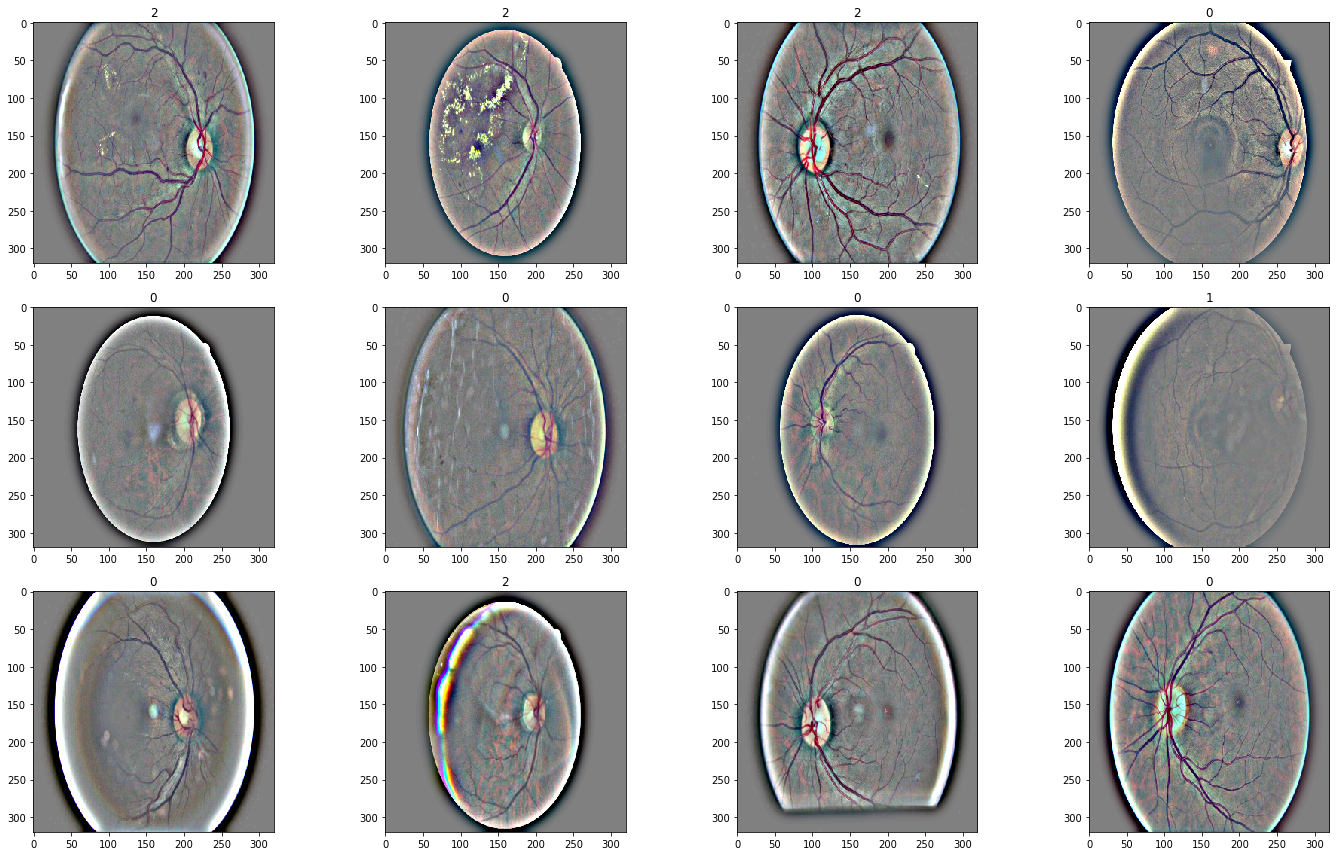

In [9]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread(f'{image_path}')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #img = crop_image_from_gray(img)
        img = cv2.resize(img, (im_size,im_size))
        img = cv2.addWeighted(img,4,cv2.GaussianBlur(img, (0,0), im_size/40) ,-4 ,128)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_df)

# Processing Images

__UPDATE:__ Here we are reading just the validation set. In order to use 320x320 images, we are going to load one bucket at a time only when needed. This will let our code run without memory-related errors.

In [10]:
# validation set
N = val_df.shape[0]
x_val = np.empty((N, im_size, im_size, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm_notebook(val_df['id_code'])):
    x_val[i, :, :, :] = preprocess_image(
        f'{image_id}',
        desired_size = im_size
    )

In [11]:
y_train = pd.get_dummies(train_df['diagnosis']).values
y_val = pd.get_dummies(val_df['diagnosis']).values

print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(35126, 5)
(3662, 320, 320, 3)
(3662, 5)


# Creating multilabels

Instead of predicting a single label, we will change our target to be a multilabel problem; i.e., if the target is a certain class, then it encompasses all the classes before it. E.g. encoding a class 4 retinopathy would usually be `[0, 0, 0, 1]`, but in our case we will predict `[1, 1, 1, 1]`. For more details, please check out [Lex's kernel](https://www.kaggle.com/lextoumbourou/blindness-detection-resnet34-ordinal-targets).

In [12]:
y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

y_val_multi = np.empty(y_val.shape, dtype=y_val.dtype)
y_val_multi[:, 4] = y_val[:, 4]

for i in range(3, -1, -1):
    y_val_multi[:, i] = np.logical_or(y_val[:, i], y_val_multi[:, i+1])

print("Y_train multi: {}".format(y_train_multi.shape))
print("Y_val multi: {}".format(y_val_multi.shape))

Y_train multi: (35126, 5)
Y_val multi: (3662, 5)


In [13]:
y_train = y_train_multi
y_val = y_val_multi

In [14]:
# delete the uneeded df
del new_train
del old_train
del val_df
gc.collect()

27267

# Creating keras callback for QWK

---

I had to change this function, in order to consider the best kappa score among all the buckets.

In [15]:
class Metrics(Callback):

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_val = y_val.sum(axis=1) - 1
        
        y_pred = self.model.predict(X_val) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('model.h5')

        return

# Data Generator

In [16]:
def create_datagen():
    return ImageDataGenerator(
        featurewise_std_normalization = True,
        horizontal_flip = True,
        vertical_flip = True,
        rotation_range = 360
    )

# Model: DenseNet-121

In [17]:
densenet = DenseNet121(
    weights='../input/densenet-keras/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(im_size,im_size,3)
)

In [18]:
def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.0001,decay=1e-6),
        metrics=['accuracy']
    )
    
    return model

In [19]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 10, 10, 1024)      7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________


# Training & Evaluation

In [20]:
#train_df = train_df.reset_index(drop=True)
bucket_num = 8
div = round(train_df.shape[0]/bucket_num)

In [21]:
df_init = {
    'val_loss': [0.0],
    'val_acc': [0.0],
    'loss': [0.0], 
    'acc': [0.0],
    'bucket': [0.0]
}
results = pd.DataFrame(df_init)

In [22]:
# I found that changing the nr. of epochs for each bucket helped in terms of performances
epochs = [5,5,10,15,15,20,20,30]
kappa_metrics = Metrics()
kappa_metrics.val_kappas = []

In [23]:
for i in range(0,bucket_num):
    if i != (bucket_num-1):
        print("Bucket Nr: {}".format(i))
        
        N = train_df.iloc[i*div:(1+i)*div].shape[0]
        x_train = np.empty((N, im_size, im_size, 3), dtype=np.uint8)
        for j, image_id in enumerate(tqdm_notebook(train_df.iloc[i*div:(1+i)*div,0])):
            x_train[j, :, :, :] = preprocess_image_old(f'{image_id}', desired_size = im_size)

        data_generator = create_datagen().flow(x_train, y_train[i*div:(1+i)*div,:], batch_size=BATCH_SIZE)
        history = model.fit_generator(
                        data_generator,
                        steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
                        epochs=epochs[i],
                        validation_data=(x_val, y_val),
                        callbacks=[kappa_metrics]
                        )
        
        dic = history.history
        df_model = pd.DataFrame(dic)
        df_model['bucket'] = i
    else:
        print("Bucket Nr: {}".format(i))
        
        N = train_df.iloc[i*div:].shape[0]
        x_train = np.empty((N, im_size, im_size, 3), dtype=np.uint8)
        for j, image_id in enumerate(tqdm_notebook(train_df.iloc[i*div:,0])):
            x_train[j, :, :, :] = preprocess_image_old(f'{image_id}', desired_size = im_size)
        data_generator = create_datagen().flow(x_train, y_train[i*div:,:], batch_size=BATCH_SIZE)
        
        history = model.fit_generator(
                        data_generator,
                        steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
                        epochs=epochs[i],
                        validation_data=(x_val, y_val),
                        callbacks=[kappa_metrics]
                        )
        
        dic = history.history
        df_model = pd.DataFrame(dic)
        df_model['bucket'] = i

    results = results.append(df_model)
    
    del data_generator
    del x_train
    gc.collect()
    
    print('-'*40)

Bucket Nr: 0



Epoch 1/5
138/137 [==============================] - 180s 1s/step - loss: 0.3455 - acc: 0.8517 - val_loss: 0.2448 - val_acc: 0.8984
val_kappa: 0.6792
Validation Kappa has improved. Saving model.
Epoch 2/5
138/137 [==============================] - 132s 960ms/step - loss: 0.2317 - acc: 0.9068 - val_loss: 0.1857 - val_acc: 0.9218
val_kappa: 0.8302
Validation Kappa has improved. Saving model.
Epoch 3/5
138/137 [==============================] - 133s 962ms/step - loss: 0.2038 - acc: 0.9203 - val_loss: 0.2427 - val_acc: 0.8949
val_kappa: 0.6534
Epoch 4/5
138/137 [==============================] - 131s 952ms/step - loss: 0.1878 - acc: 0.9254 - val_loss: 0.1839 - val_acc: 0.9288
val_kappa: 0.8199
Epoch 5/5
138/137 [==============================] - 132s 956ms/step - loss: 0.1782 - acc: 0.9297 - val_loss: 0.2089 - val_acc: 0.9222
val_kappa: 0.8404
Validation Kappa has improved. Saving model.
----------------------------------------
Bucket Nr: 1



Epoch 1/5
138/137 [==============================] - 138s 1s/step - loss: 0.1894 - acc: 0.9271 - val_loss: 0.2063 - val_acc: 0.9244
val_kappa: 0.8659
Validation Kappa has improved. Saving model.
Epoch 2/5
138/137 [==============================] - 132s 958ms/step - loss: 0.1823 - acc: 0.9317 - val_loss: 0.2212 - val_acc: 0.9127
val_kappa: 0.8466
Epoch 3/5
138/137 [==============================] - 132s 959ms/step - loss: 0.1671 - acc: 0.9364 - val_loss: 0.2120 - val_acc: 0.9105
val_kappa: 0.7112
Epoch 4/5
138/137 [==============================] - 133s 960ms/step - loss: 0.1667 - acc: 0.9356 - val_loss: 0.1796 - val_acc: 0.9274
val_kappa: 0.8449
Epoch 5/5
138/137 [==============================] - 132s 956ms/step - loss: 0.1609 - acc: 0.9378 - val_loss: 0.1862 - val_acc: 0.9273
val_kappa: 0.8652
----------------------------------------
Bucket Nr: 2



Epoch 1/10
138/137 [==============================] - 141s 1s/step - loss: 0.1842 - acc: 0.9288 - val_loss: 0.1762 - val_acc: 0.9294
val_kappa: 0.8280
Epoch 2/10
138/137 [==============================] - 132s 953ms/step - loss: 0.1704 - acc: 0.9338 - val_loss: 0.1758 - val_acc: 0.9291
val_kappa: 0.8533
Epoch 3/10
138/137 [==============================] - 131s 950ms/step - loss: 0.1664 - acc: 0.9356 - val_loss: 0.2008 - val_acc: 0.9187
val_kappa: 0.8334
Epoch 4/10
138/137 [==============================] - 133s 967ms/step - loss: 0.1641 - acc: 0.9366 - val_loss: 0.1917 - val_acc: 0.9179
val_kappa: 0.8639
Epoch 5/10
138/137 [==============================] - 133s 964ms/step - loss: 0.1552 - acc: 0.9415 - val_loss: 0.1797 - val_acc: 0.9270
val_kappa: 0.8666
Validation Kappa has improved. Saving model.
Epoch 6/10
138/137 [==============================] - 133s 962ms/step - loss: 0.1548 - acc: 0.9414 - val_loss: 0.2272 - val_acc: 0.9038
val_kappa: 0.7217
Epoch 7/10
138/137 [=============


Epoch 1/15
138/137 [==============================] - 137s 990ms/step - loss: 0.1659 - acc: 0.9371 - val_loss: 0.2183 - val_acc: 0.9215
val_kappa: 0.8486
Epoch 2/15
138/137 [==============================] - 132s 958ms/step - loss: 0.1584 - acc: 0.9401 - val_loss: 0.1962 - val_acc: 0.9317
val_kappa: 0.8660
Epoch 3/15
138/137 [==============================] - 133s 961ms/step - loss: 0.1498 - acc: 0.9451 - val_loss: 0.1936 - val_acc: 0.9241
val_kappa: 0.8122
Epoch 4/15
138/137 [==============================] - 132s 959ms/step - loss: 0.1421 - acc: 0.9453 - val_loss: 0.2112 - val_acc: 0.9309
val_kappa: 0.8023
Epoch 5/15
138/137 [==============================] - 133s 965ms/step - loss: 0.1370 - acc: 0.9470 - val_loss: 0.3143 - val_acc: 0.8946
val_kappa: 0.6152
Epoch 6/15
138/137 [==============================] - 134s 972ms/step - loss: 0.1349 - acc: 0.9491 - val_loss: 0.1774 - val_acc: 0.9279
val_kappa: 0.8621
Epoch 7/15
138/137 [==============================] - 134s 968ms/step - los


Epoch 1/15
138/137 [==============================] - 138s 1s/step - loss: 0.1762 - acc: 0.9330 - val_loss: 0.1957 - val_acc: 0.9270
val_kappa: 0.8239
Epoch 2/15
138/137 [==============================] - 132s 954ms/step - loss: 0.1535 - acc: 0.9397 - val_loss: 0.1934 - val_acc: 0.9276
val_kappa: 0.8552
Epoch 3/15
138/137 [==============================] - 131s 951ms/step - loss: 0.1456 - acc: 0.9410 - val_loss: 0.2041 - val_acc: 0.9250
val_kappa: 0.8593
Epoch 4/15
138/137 [==============================] - 133s 960ms/step - loss: 0.1421 - acc: 0.9446 - val_loss: 0.2811 - val_acc: 0.9091
val_kappa: 0.8442
Epoch 5/15
138/137 [==============================] - 132s 959ms/step - loss: 0.1364 - acc: 0.9468 - val_loss: 0.1729 - val_acc: 0.9335
val_kappa: 0.8721
Validation Kappa has improved. Saving model.
Epoch 6/15
138/137 [==============================] - 134s 969ms/step - loss: 0.1319 - acc: 0.9480 - val_loss: 0.2685 - val_acc: 0.9063
val_kappa: 0.7840
Epoch 7/15
138/137 [=============

In [24]:
results = results.iloc[1:]
results['kappa'] = kappa_metrics.val_kappas
results = results.reset_index()
results = results.rename(index=str, columns={"index": "epoch"})
results

,epoch,val_loss,val_acc,loss,acc,bucket,kappa
0,0,0.244841,0.898416,0.346100,0.851150,0.0,0.679185
1,1,0.185685,0.921846,0.231833,0.906718,0.0,0.830222
2,2,0.242681,0.894921,0.204159,0.920155,0.0,0.653361
3,3,0.183855,0.928837,0.188251,0.925347,0.0,0.819928
4,4,0.208907,0.922174,0.178913,0.929310,0.0,0.840432
5,0,0.206333,0.924358,0.188189,0.927625,1.0,0.865917
6,1,0.221225,0.912725,0.181657,0.931997,1.0,0.846637
7,2,0.211957,0.910486,0.167603,0.936005,1.0,0.711246
8,3,0.179617,0.927362,0.166775,0.935732,1.0,0.844910
9,4,0.186189,0.927253,0.160960,0.937918,1.0,0.865161


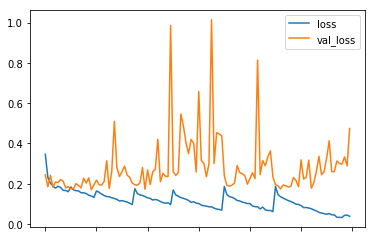

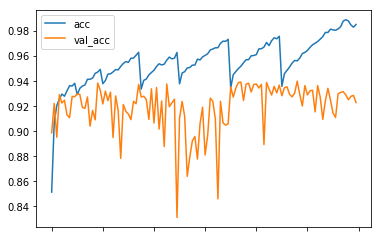

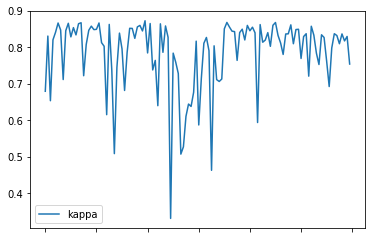

In [25]:
results[['loss', 'val_loss']].plot()
results[['acc', 'val_acc']].plot()
results[['kappa']].plot()
results.to_csv('model_results.csv',index=False)

# Find best threshold

In [26]:
model.load_weights('model.h5')
y_val_pred = model.predict(x_val)

def compute_score_inv(threshold):
    y1 = y_val_pred > threshold
    y1 = y1.astype(int).sum(axis=1) - 1
    y2 = y_val.sum(axis=1) - 1
    score = cohen_kappa_score(y1, y2, weights='quadratic')
    
    return 1 - score

simplex = scipy.optimize.minimize(
    compute_score_inv, 0.5, method='nelder-mead'
)

best_threshold = simplex['x'][0]

y1 = y_val_pred > best_threshold
y1 = y1.astype(int).sum(axis=1) - 1
y2 = y_val.sum(axis=1) - 1
score = cohen_kappa_score(y1, y2, weights='quadratic')
print('Threshold: {}'.format(best_threshold))
print('Validation QWK score with best_threshold: {}'.format(score))

y1 = y_val_pred > .5
y1 = y1.astype(int).sum(axis=1) - 1
score = cohen_kappa_score(y1, y2, weights='quadratic')
print('Validation QWK score with .5 threshold: {}'.format(score))

Threshold: 0.5328125
Validation QWK score with best_threshold: 0.8732762517488468
Validation QWK score with .5 threshold: 0.8721110151017945


## [Inference Kernel](https://www.kaggle.com/raimonds1993/aptos19-densenet-inference-old-new-data/data?scriptVersionId=17252732)

**Thanks for reading it all! Please let me know if you have any ideas to improve this process.**

**Hope you liked it.**